In [1]:
import tensorflow as tf

In [2]:

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

In [3]:
import numpy as np

# add empty color dimension
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

In [4]:
# recude memory and compute time
NUMBER_OF_SAMPLES = 50000

In [5]:
x_train_samples = x_train[:NUMBER_OF_SAMPLES]

In [6]:
y_train_samples = y_train[:NUMBER_OF_SAMPLES]

In [7]:
import skimage.data
import skimage.transform

x_train_224 = np.array([skimage.transform.resize(image, (32, 32)) for image in x_train_samples])

In [8]:
from tensorflow.keras.applications.resnet50 import ResNet50

# https://keras.io/applications/#mobilenet
# https://arxiv.org/pdf/1704.04861.pdf
# from tensorflow.keras.applications.mobilenet import MobileNet

model = ResNet50(classes=10, weights=None, input_shape=(32, 32, 1))
# model = MobileNet(classes=10, weights=None, input_shape=(32, 32, 1))

model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 1)]  0           []                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 38, 38, 1)    0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 16, 16, 64)   3200        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 16, 16, 64)   256         ['conv1_conv[0][0]']             
                                                                                           

In [9]:
%%time

BATCH_SIZE=32
EPOCHS = 2

model.compile(loss='sparse_categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

history = model.fit(x_train_224, y_train_samples, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split=0.2, verbose=1)


Epoch 1/2
1250/1250 [==============================] - 66s 42ms/step - loss: 0.8172 - accuracy: 0.7549 - val_loss: 0.5190 - val_accuracy: 0.8118
Epoch 2/2
1250/1250 [==============================] - 52s 41ms/step - loss: 0.5230 - accuracy: 0.8296 - val_loss: 0.3790 - val_accuracy: 0.8657
CPU times: user 1min 48s, sys: 2.79 s, total: 1min 51s
Wall time: 2min 27s


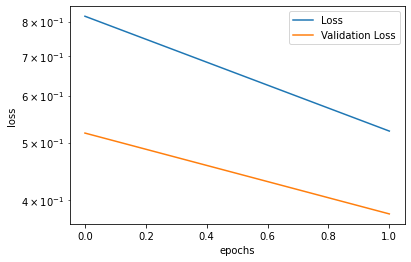

In [10]:
import matplotlib.pyplot as plt

plt.xlabel('epochs')
plt.ylabel('loss')

plt.yscale('log')

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Loss', 'Validation Loss'])

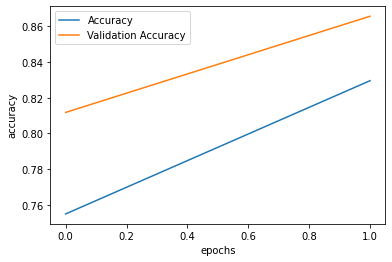

In [11]:
plt.xlabel('epochs')
plt.ylabel('accuracy')

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['Accuracy', 'Validation Accuracy'])

In [12]:
x_test_224 = np.array([skimage.transform.resize(image, (32, 32)) for image in x_test])

1/1 [==============================] - 1s 826ms/step


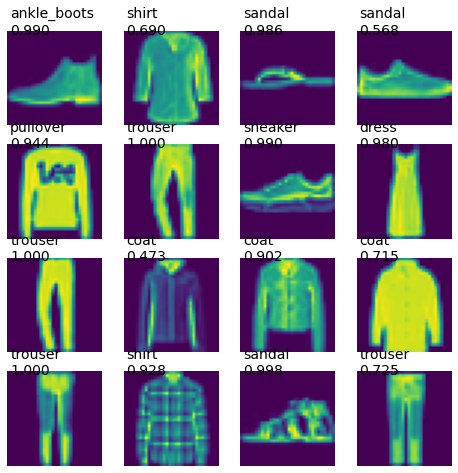

In [13]:
LABEL_NAMES = ['t_shirt', 'trouser', 'pullover', 'dress', 'coat', 'sandal', 'shirt', 'sneaker', 'bag', 'ankle_boots']


def plot_predictions(images, predictions):
  n = images.shape[0]
  nc = int(np.ceil(n / 4))
  f, axes = plt.subplots(nc, 4)
  for i in range(nc * 4):
    y = i // 4
    x = i % 4
    axes[x, y].axis('off')
    
    label = LABEL_NAMES[np.argmax(predictions[i])]
    confidence = np.max(predictions[i])
    if i > n:
      continue
    axes[x, y].imshow(images[i])
    axes[x, y].text(0.5, 0.5, label + '\n%.3f' % confidence, fontsize=14)

  plt.gcf().set_size_inches(8, 8)  

plot_predictions(np.squeeze(x_test_224[:16]), 
                 model.predict(x_test_224[:16]))

In [14]:
train_loss, train_accuracy = model.evaluate(x_train_224, y_train_samples, batch_size=BATCH_SIZE)
train_accuracy

1563/1563 [==============================] - 21s 13ms/step - loss: 0.3586 - accuracy: 0.8712


0.8712000250816345

In [16]:
test_loss, test_accuracy = model.evaluate(x_test_224, y_test, batch_size=BATCH_SIZE)
test_accuracy

313/313 [==============================] - 5s 16ms/step - loss: 0.4060 - accuracy: 0.8555


0.8554999828338623

In [26]:
predictions = model.predict(x_test_224)
predictions = np.argmax(predictions, axis=1)

313/313 [==============================] - 4s 11ms/step


In [27]:
from sklearn.metrics import confusion_matrix, classification_report
confusion_matrix(y_test, predictions)

array([[872,   0,   7,  22,   7,   1,  88,   0,   3,   0],
       [  5, 938,   1,  38,  12,   0,   4,   0,   2,   0],
       [ 30,   0, 725,   9,  93,   0, 140,   0,   3,   0],
       [ 36,   0,   6, 836,  67,   0,  55,   0,   0,   0],
       [  2,   0,  57,  15, 737,   0, 187,   0,   2,   0],
       [  1,   0,   0,   1,   0, 954,   0,  22,   0,  22],
       [192,   0,  66,  23,  57,   0, 651,   0,  11,   0],
       [  0,   0,   0,   0,   0,  22,   0, 955,   0,  23],
       [  6,   0,   3,   7,   4,   4,  28,   4, 944,   0],
       [  0,   0,   0,   1,   0,   4,   2,  50,   0, 943]])

In [29]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.76      0.87      0.81      1000
           1       1.00      0.94      0.97      1000
           2       0.84      0.72      0.78      1000
           3       0.88      0.84      0.86      1000
           4       0.75      0.74      0.75      1000
           5       0.97      0.95      0.96      1000
           6       0.56      0.65      0.60      1000
           7       0.93      0.95      0.94      1000
           8       0.98      0.94      0.96      1000
           9       0.95      0.94      0.95      1000

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000

